【数据背景】新能源车电池模组的充放电数据是指电池在使用过程中进行充电和放电时所记录的相关信息。这些数据包含了电池的性能指标、工作状态和使用情况，可以帮助监测和评估电池的健康状况、性能表现以及寿命预测。这些数据通过车辆的电池管理系统（Battery Management System，简称BMS）进行监测和记录。基于这些数据，制造商和维护人员可以进行电池性能分析、故障诊断以及优化电池使用和充电策略。同时，这些数据也可以用于研究和改进电池技术，提高新能源车的续航里程和可靠性。

【应用领域】AI+电池充放电

【文件目录】20个#x的csv数据文件（比如第一辆的名称就是#1.csv）

【数据说明】共20辆新能源车的电池模组充放电数据，每个#x代表一辆新能源车电池模组的充放电数据，数据时间段为2019/07/25—2021/11/15，数据跨度约29个月，数据集大小约1.1GB。每个csv数据表包含10个数据字段，具体如下：

1. record_time：时间戳
2. soc：车辆电池剩余容量，单位为%
3. pack_voltage：电池模组电压，单位为V
4. charge_current：充电电流，单位为A
5. max_cell_voltage：电池单体最大电压，单位为V
6. min_cell_voltage：电池单体最小电压，单位为V
7. max_temperature：最高温度，单位为℃
8. min_temperature：最低温度，单位为℃
9. available_energy：可用能量，单位为kW
10. available_capacity：可用容量，单位为Ah

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras import layers  
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore", category=UserWarning)

# Set the path to the dataset
PATH = "D:/New-Energy-Battery/dataset/"

# Set the plot style  
sns.set(style="whitegrid")

# 1. Import all CSV files  
data_files = glob.glob(PATH + "/*.csv")  # Assuming CSV files are in data directory  
dataframes = []

for file in data_files:
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Remove the first column
    # Append filename as a column to distinguish different vehicles
    df['vehicle_id'] = file.split('\\')[-1].split(".")[0]  # Get filename as vehicle ID
    dataframes.append(df)

# Merge all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Convert record_time to datetime format  
data['record_time'] = pd.to_datetime(data['record_time'], format='%Y%m%d%H%M%S', errors='coerce')  

# Drop missing values
data.dropna(inplace=True)

Epoch 1/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 400s 1ms/step - loss: 10.6036 - mae: 1.1151 - val_loss: 0.7959 - val_mae: 0.6660
Epoch 2/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 396s 1ms/step - loss: 0.7287 - mae: 0.6236 - val_loss: 0.7080 - val_mae: 0.6293
Epoch 3/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 397s 1ms/step - loss: 0.6914 - mae: 0.5994 - val_loss: 0.7046 - val_mae: 0.6349
Epoch 4/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 399s 1ms/step - loss: 0.6459 - mae: 0.5805 - val_loss: 0.6327 - val_mae: 0.5760
Epoch 5/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 400s 1ms/step - loss: 0.6249 - mae: 0.5701 - val_loss: 0.6513 - val_mae: 0.5928
Epoch 6/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 396s 1ms/step - loss: 0.6054 - mae: 0.5617 - val_loss: 0.6278 - val_mae: 0.5614
Epoch 7/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 398s 1ms/step - loss: 0.5962 - mae: 0.5552 - val_loss: 0.6444 - val_mae: 0.6112
Epoch 8/20
322015/322015 ━━━━━━━━━━━━━━━━━━━━ 398s 1ms/step - loss: 0.5864 - mae: 0.5491 - val_loss: 0.5760 - val_mae

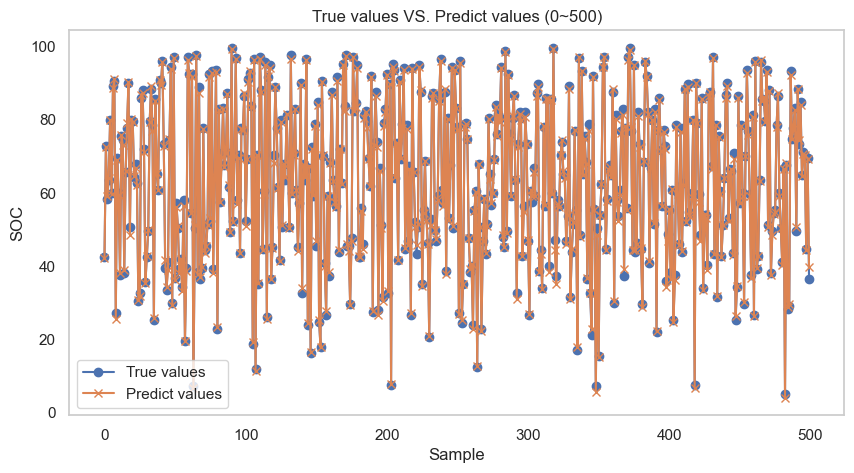

In [2]:
# Select features and target
features = data[['pack_voltage (V)', 'charge_current (A)',
                  'max_cell_voltage (V)', 'min_cell_voltage (V)',
                  'max_temperature (℃)', 'min_temperature (℃)',
                  'available_energy (kw)', 'available_capacity (Ah)']]
target = data['soc']  # Assume we are predicting the battery state of charge (SOC)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for CNN (samples, height, width, channels)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  # (samples, features, 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  # (samples, features, 1)

# Build the CNN model
model = keras.Sequential([
    layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=2, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model and capture the history
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae}")

# Print the loss values from training
print("Training Loss Values:")
for epoch, loss in enumerate(history.history['loss']):
    print(f"Epoch {epoch + 1}: Loss = {loss}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Visualize prediction results
LEN = 500
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:LEN], label='True values', marker='o')
plt.plot(predictions[:LEN], label='Predict values', marker='x')
plt.xlabel('Sample')
plt.ylabel('SOC')
plt.title(f'True values VS. Predict values (0~{LEN})')
plt.legend()
plt.grid()
plt.show()

In [3]:
# Calculate and print R^2 score
print("Accuracy rate:", r2_score(y_test, predictions))

Accuracy rate: 0.9986072350637346


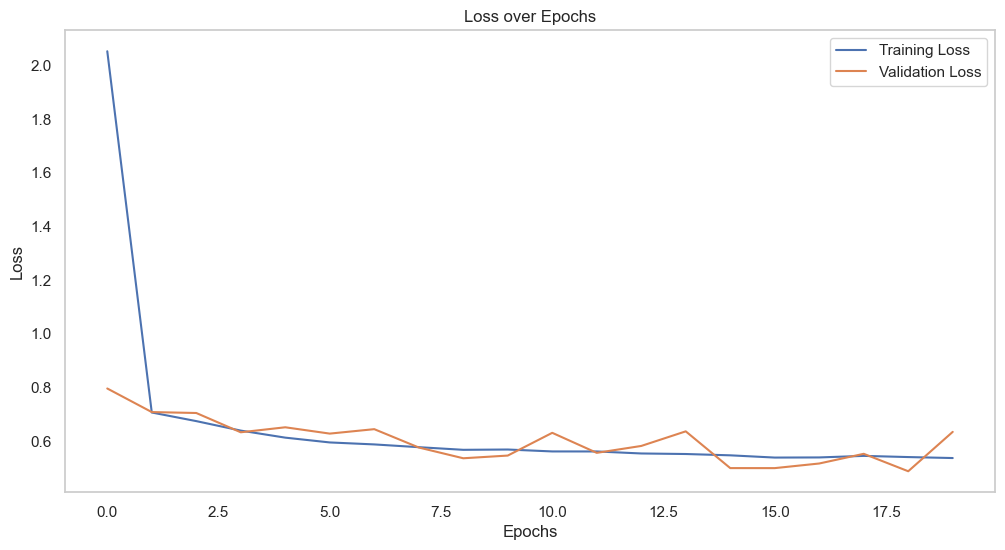

In [4]:
# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()